## Regression Model Training + Testing

In [1]:
import pandas as pd
import numpy as np

In [2]:
expression_df = pd.read_csv("../data/processed_data/expression_data.csv")

In [3]:
drug_response_df = pd.read_csv("../data/processed_data/drug_response_data.csv")

Make sure data is aligned

In [4]:
common_ids = expression_df.index.intersection(drug_response_df.index)

X = expression_df.loc[common_ids]
y = drug_response_df.loc[common_ids]

assert (X.index == y.index).all() ## does nothing if WORKS, will throw error otherwise, keep that as a note

No error, therefore it is aligned

#### Selecting Drugs to Train

First we must determine which drugs will the model be trained on

In [5]:
valid_counts = drug_response_df.notna().sum()
training_drugs = valid_counts[valid_counts >= 50].index.tolist()
print(len(training_drugs))

127


In [6]:
print(training_drugs)

['COSMIC_ID', '5-Fluorouracil', 'ABT737', 'AGI-5198', 'AGK2', 'AMG-319', 'AT13148', 'AZ6102', 'AZD3759', 'AZD4547', 'AZD5363', 'AZD6738', 'AZD7762', 'AZD8186', 'Afatinib', 'Afuresertib', 'Alpelisib', 'Avagacestat', 'Axitinib', 'BIBR-1532', 'BMS-536924', 'BMS-754807', 'Bortezomib', 'Bosutinib', 'Buparlisib', 'Camptothecin', 'Cediranib', 'Cisplatin', 'Crizotinib', 'Cyclophosphamide', 'Dabrafenib', 'Dactinomycin', 'Dactolisib', 'Dasatinib', 'Docetaxel', 'Doramapimod', 'EHT-1864', 'EPZ004777', 'EPZ5676', 'Entinostat', 'Epirubicin', 'Erlotinib', 'Foretinib', 'Fulvestrant', 'GDC0810', 'GNE-317', 'GSK1904529A', 'GSK2578215A', 'GSK343', 'GSK591', 'Gefitinib', 'Gemcitabine', 'I-BRD9', 'Ipatasertib', 'Irinotecan', 'JQ1', 'KU-55933', 'LGK974', 'LJI308', 'Lapatinib', 'Lenalidomide', 'Lestaurtinib', 'Linsitinib', 'Luminespib', 'MG-132', 'MIRA-1', 'MK-1775', 'MK-2206', 'MK-8776', 'Motesanib', 'NU7441', 'NVP-ADW742', 'Navitoclax', 'Nilotinib', 'Nutlin-3a (-)', 'OSI-027', 'Olaparib', 'Osimertinib', 'O

In [7]:
training_drugs = training_drugs[1 :]
print(training_drugs)

['5-Fluorouracil', 'ABT737', 'AGI-5198', 'AGK2', 'AMG-319', 'AT13148', 'AZ6102', 'AZD3759', 'AZD4547', 'AZD5363', 'AZD6738', 'AZD7762', 'AZD8186', 'Afatinib', 'Afuresertib', 'Alpelisib', 'Avagacestat', 'Axitinib', 'BIBR-1532', 'BMS-536924', 'BMS-754807', 'Bortezomib', 'Bosutinib', 'Buparlisib', 'Camptothecin', 'Cediranib', 'Cisplatin', 'Crizotinib', 'Cyclophosphamide', 'Dabrafenib', 'Dactinomycin', 'Dactolisib', 'Dasatinib', 'Docetaxel', 'Doramapimod', 'EHT-1864', 'EPZ004777', 'EPZ5676', 'Entinostat', 'Epirubicin', 'Erlotinib', 'Foretinib', 'Fulvestrant', 'GDC0810', 'GNE-317', 'GSK1904529A', 'GSK2578215A', 'GSK343', 'GSK591', 'Gefitinib', 'Gemcitabine', 'I-BRD9', 'Ipatasertib', 'Irinotecan', 'JQ1', 'KU-55933', 'LGK974', 'LJI308', 'Lapatinib', 'Lenalidomide', 'Lestaurtinib', 'Linsitinib', 'Luminespib', 'MG-132', 'MIRA-1', 'MK-1775', 'MK-2206', 'MK-8776', 'Motesanib', 'NU7441', 'NVP-ADW742', 'Navitoclax', 'Nilotinib', 'Nutlin-3a (-)', 'OSI-027', 'Olaparib', 'Osimertinib', 'Oxaliplatin', 

We can see that the drugs with at least 50 samples is the most effective number since we get 127 drugs. If we increase the samples to 52 we only get 14 samples. However to be safe we will:
- Log the number of samples used per drug
- Use cross-validation per drug to mitigate variance
- Prioritize post-analysis of drugs with best regression performance or biological relevance

#### Deciding the Regression Model to Use

To help determine what model is best, we will first plot some graphs to help us determine any relationships

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

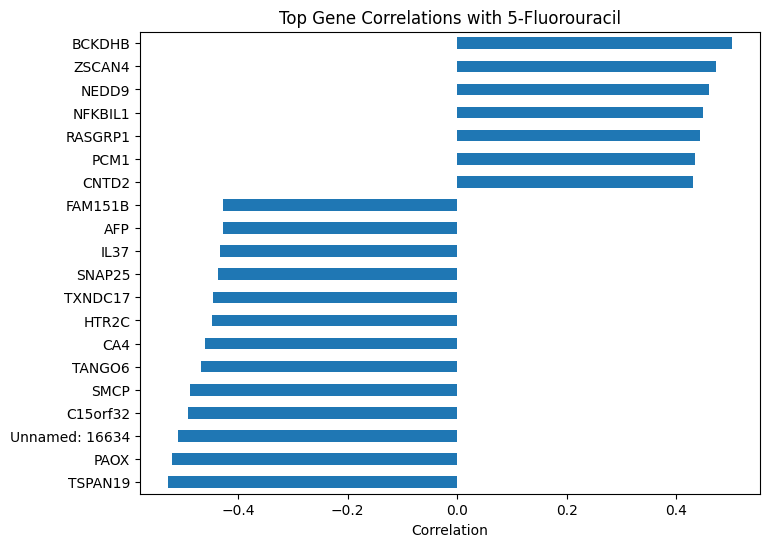

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

drug = training_drugs[0]

# Get cell lines with non-null drug response
y = drug_response_df[drug].dropna()

# Intersect again with expression data just in case
common_index = y.index.intersection(expression_df.index)

# Final aligned X and y
y = y.loc[common_index]
X = expression_df.loc[common_index]

# Assuming y = drug response for one drug
# and X = expression data aligned to y

# 1. Compute correlation between each gene and drug response
correlations = X.corrwith(y).dropna()

# 2. Get top 20 genes by **absolute correlation**
top_genes = correlations.abs().sort_values(ascending=False).head(20).index
correlations[top_genes].sort_values().plot(kind='barh', figsize=(8, 6))
plt.title(f"Top Gene Correlations with {drug}")
plt.xlabel("Correlation")
plt.show()

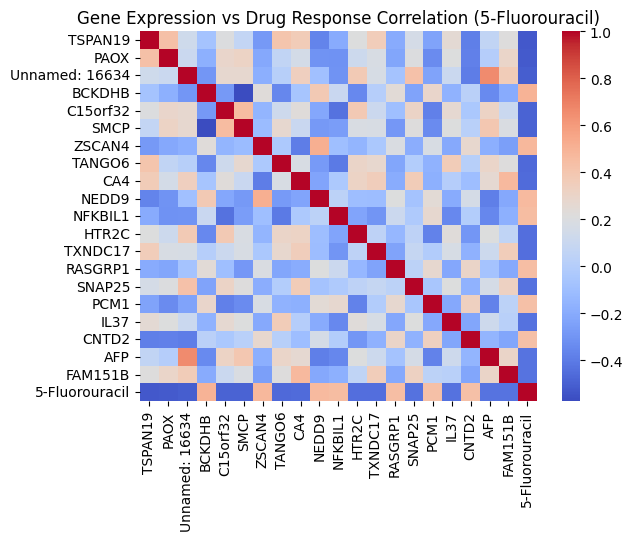

In [10]:

correlations = X.corrwith(y).dropna()
top_genes = correlations.abs().sort_values(ascending=False).head(20).index

sns.heatmap(X[top_genes].join(y).corr(), cmap="coolwarm", annot=False)
plt.title(f"Gene Expression vs Drug Response Correlation ({drug})")
plt.show()


#### Model Testing

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
drug = training_drugs[0]

# drug is put in and we get the drug response vector without na
y = drug_response_df[drug].dropna()

# only keep cell lines that are in both y and expression_df
common_index = y.index.intersection(expression_df.index)

# Final aligned data
y = y.loc[common_index]
X = expression_df.loc[common_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2 Score:", r2)

MSE: 2.3908282242327683
R^2 Score: 0.010375988374960454


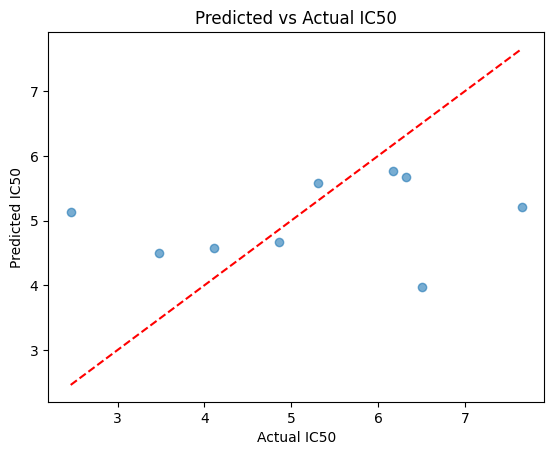

In [13]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual IC50")
plt.ylabel("Predicted IC50")
plt.title("Predicted vs Actual IC50")
plt.show()

MSE = average of the squared differences between predicted and actual values.

R² = how much of the variance in y is explained by the model.

Since the MSE value is above 1.5 and the r squared values are below 0, it tells us that the **Gradient Boosting** is performing worse than just predicing the mean itself

#### Random Testing to find best model

In [14]:
# Find top 100 most correlated features with y
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
top_features = correlations.head(100).index

# Reduce your input
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]


## _____________________________________________________________________
## Trying with reduced features

regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
regressor.fit(X_train_reduced, y_train)

y_pred = regressor.predict(X_test_reduced)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2 Score:", r2)

MSE: 3.5943208730644716
R^2 Score: -0.48777992723050967


In [15]:
# Find top 500 most correlated features with y
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
top_features = correlations.head(500).index

# Reduce your input
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]


## _____________________________________________________________________
## Trying with reduced features

regressor = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
regressor.fit(X_train_reduced, y_train)

y_pred = regressor.predict(X_test_reduced)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2 Score:", r2)

MSE: 3.3031126961770507
R^2 Score: -0.36724152915223507


In [16]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X preview:")
display(X.head())
print("y preview:")
print(y.head())

X shape: (44, 17738)
y shape: (44,)
X preview:


,COSMIC_ID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,LINC00526,PPY2,Unnamed: 17730,Unnamed: 17731,KRT18P55,Unnamed: 17733,POLRMTP1,UBL5P2,TBC1D3P5,Unnamed: 17737
0,906826,7.632023,2.964585,10.379553,3.614794,3.380681,3.324692,3.566350,8.204530,5.235118,...,6.786925,2.997054,3.109774,7.882377,3.331134,2.852537,3.130696,9.986616,3.073724,7.284733
1,910927,8.712338,2.643508,9.880733,3.956230,3.236620,3.241246,2.931034,8.191246,5.426841,...,3.143006,3.112145,2.930254,8.707886,2.886574,2.685307,3.176239,9.113243,2.916274,7.059092
2,907045,3.455951,3.290184,11.570155,5.560883,3.571228,3.370885,3.115533,7.801258,5.479718,...,4.016486,2.933926,7.898627,8.684150,3.424035,3.124607,3.173933,9.518999,3.240584,6.124752
3,925338,5.500209,3.104776,10.910371,4.481802,3.697625,3.272956,3.040479,7.273915,4.960929,...,4.295694,3.118596,2.861967,7.826914,2.750728,2.881426,3.266288,9.780435,3.338500,7.748498
4,910704,6.280456,2.734091,10.332254,6.078175,3.499351,3.264717,3.234723,8.355618,6.182757,...,3.918447,3.022542,3.691863,8.939406,3.187884,3.110821,3.151326,8.864750,3.067727,10.839140


y preview:
0    5.369619
1    5.096717
2    6.868742
3    6.095529
4    5.304199
Name: 5-Fluorouracil, dtype: float64


The issue arises due to the expression data. There are 17,738 gene features but only 44 cell lines. This issue is usually known as the "small n, large p" problem. The issue is that the model I am trying to create is trying to learn from 44 examples but there are 18,000 variables. This is leading to overfitting with my models. Models like Gradient Boosting, Random Forest, and SVR would struggle with only 44 samples for high-dimensional data.

From these new discoveries, the regression model will be just be omitted from the pipeline and instead I'll straight use a classification model to drive if patients will either be responsive or non-responsive to the drug (given a cell line's gene expression, can we predict whether a drug will be effective? this is what we are answering)

Even if the IC50 value is hard to predict exactly, knowing whether it's above or below a biologically relevant threshold is often enough to guide decisions.